## CNN Base

### Data Preparation

### Resources
https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot.xarray
import sys
import tensorflow as tf
from tensorflow import keras
import os

%matplotlib inline


sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray
from sklearn.model_selection import train_test_split

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def convert_nan(arr):
    nans=np.isnan(arr)
    arr[nans]=0
    return arr

def add_dimension(arr):
    images=np.expand_dims(arr, axis=3)
    return images
    

In [5]:
# Reading Data
dir_name="../data/member_001"
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)


In [6]:
chl_images=add_dimension(np.array(convert_nan(chl.Chl.data)))
mld_images=add_dimension(np.array(convert_nan(mld.MLD.data)))
sss_images=add_dimension(np.array(convert_nan(sss.SSS.data)))
sst_images=add_dimension(np.array(convert_nan(sst.SST.data)))
pco2_images=add_dimension(np.array(convert_nan(pco2.pCO2.data)))



In [7]:
X = np.stack((chl_images, mld_images, sss_images, sst_images), axis = 1)


In [8]:
X.shape

(421, 4, 180, 360, 1)

In [9]:
pco2_images.shape

(421, 180, 360, 1)

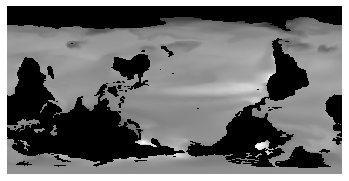

In [68]:
plot_image(pco2_images[0])

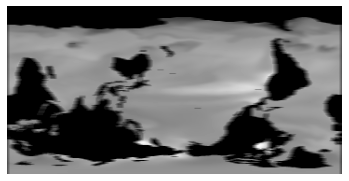

In [61]:
batch_size, height, width,channels = pco2_images.shape
channels=1

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(pco2_images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

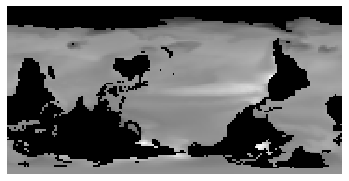

In [69]:
conv = keras.layers.Conv2D(filters=32, kernel_size=1, strides=2,
                           padding="SAME", activation="relu")
plot_image(conv(pco2_images)[0,:,:,0])
plt.show()

In [62]:
from functools import partial

DefaultConv3D = partial(keras.layers.Conv3D,
                        kernel_size=3,activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv3D(filters=64, input_shape=[4,180, 360, 1]),
    DefaultConv3D(filters=64),
    keras.layers.MaxPooling3D(pool_size=3),
    DefaultConv3D(filters=128),
    DefaultConv3D(filters=128),
    keras.layers.Dropout(0.5),
    keras.layers.UpSampling3D(size=(1,3,3)),
    DefaultConv3D(filters=64),
    DefaultConv3D(filters=2),
    DefaultConv3D(filters=1,kernel_size=1),
    keras.layers.Reshape(pco2_images[0].shape)
   
])

In [63]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_83 (Conv3D)           (None, 4, 180, 360, 64)   1792      
_________________________________________________________________
conv3d_84 (Conv3D)           (None, 4, 180, 360, 64)   110656    
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 1, 60, 120, 64)    0         
_________________________________________________________________
conv3d_85 (Conv3D)           (None, 1, 60, 120, 128)   221312    
_________________________________________________________________
conv3d_86 (Conv3D)           (None, 1, 60, 120, 128)   442496    
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 60, 120, 128)   0         
_________________________________________________________________
up_sampling3d_11 (UpSampling (None, 1, 180, 360, 128)

In [64]:
model.compile(loss="mean_squared_error", optimizer="nadam", metrics=["mean_squared_error"])


In [ ]:
history = model.fit(X,pco2_images, epochs=10, validation_data=(X,pco2_images),workers=2)


Epoch 1/10
 7/14 [==============>...............] - ETA: 31:44 - loss: 47047.8125 - mean_squared_error: 47047.8164